In [4]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import polars as pl

import sys

# Add the path to the parent directory of btEngine2
sys.path.append(r'G:\Projects\BackTesting1.0')

from btEngine2.MarketData import *
from btEngine2.TradingRule import *

def custom_format(x):
    if abs(x) < 10:
        return f"{x:.2f}"
    else:
        return f"{x:,.0f}"
    
pd.options.display.float_format = custom_format

from IPython.display import display

def display_with_title(df):
    """
    Display a DataFrame with its title if the title attribute is set.
    
    :param df: The DataFrame to display.
    """
    title = df.attrs.get('title', None)
    if title:
        print(title)
    display(df)



In [5]:
testfile = r'G:\Projects\BackTesting1.0\Data\Bloomberg\Futures\fi-us\US1 Comdty.parquet'

df = pl.read_parquet(testfile)

print(df)

shape: (11_293, 9)
┌─────────────┬───────────┬───────────┬───────────┬───┬──────────┬────────┬────────────┬───────────┐
│ Date        ┆ Open      ┆ High      ┆ Low       ┆ … ┆ Volume   ┆ Name   ┆ Carry_Clos ┆ Carry     │
│ ---         ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---    ┆ e          ┆ ---       │
│ datetime[ns ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64      ┆ str    ┆ ---        ┆ f64       │
│ ]           ┆           ┆           ┆           ┆   ┆          ┆        ┆ f64        ┆           │
╞═════════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪════════╪════════════╪═══════════╡
│ 1980-01-02  ┆ -41.875   ┆ -41.875   ┆ -43.09375 ┆ … ┆ 6297.0   ┆ US1    ┆ -29.84375  ┆ NaN       │
│ 00:00:00    ┆           ┆           ┆           ┆   ┆          ┆ Comdty ┆            ┆           │
│ 1980-01-03  ┆ -43.46875 ┆ -43.34375 ┆ -43.9375  ┆ … ┆ 7949.0   ┆ US1    ┆ -30.25     ┆ NaN       │
│ 00:00:00    ┆           ┆           ┆           ┆   ┆          ┆ Comdt

In [6]:

def mean_reversion_bounce(df, ema_period=200, atr_period=200, atr_multiplier=0.5):
    """
    Detects mean reversion bounce trades in an uptrend (price > 20-day EMA),
    with BadOHLC adjustment and persistence of uptrend on entry into bounce area.
    
    :param df: DataFrame containing price data (OHLC).
    :param ema_period: Period for the EMA (default is 20).
    :param atr_period: Period for ATR calculation (default is 14).
    :param atr_multiplier: Multiplier for ATR to define the bounce area (default is 0.4).
    :return: DataFrame with bounce signals and associated metrics.
    """
    df = df.to_pandas()
    # Step 1: Calculate the 20-day EMA
    df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()

    # Step 2: Calculate the 14-day ATR (Average True Range) with BadOHLC adjustment
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = np.abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)  # True Range
    
    # Compute normal ATR
    df['ATR'] = df['TR'].rolling(window=atr_period).mean()

    # Step 3: Replace ATR with standard deviation when BadOHLC is True
    df['ATR_SD'] = df['Close'].rolling(window=atr_period).std()
    df['Effective_ATR'] = np.where(df['BadOHLC'], df['ATR_SD'], df['ATR'])

    # Step 4: Define the bounce area using the Effective ATR
    df['Upper_Bounce_Area'] = df['EMA'] + atr_multiplier * df['Effective_ATR']
    df['Lower_Bounce_Area'] = df['EMA'] - atr_multiplier * df['Effective_ATR']

    # Step 5: Determine if the price is in an uptrend (price > EMA)
    df['Uptrend'] = df['Close'] > df['EMA']

    # Step 6: Detect when price enters the bounce area
    df['In_Bounce_Area'] = (df['Close'] >= df['Lower_Bounce_Area']) & (df['Close'] <= df['Upper_Bounce_Area'])

    # Step 7: Track if the asset was in an uptrend before entering the bounce area
    df['Uptrend_On_Entry'] = np.nan  # Initialize column to track the uptrend state at bounce entry
    df['Uptrend_On_Entry'] = df['Uptrend_On_Entry'].astype('bool')  # Convert to boolean type
    # Initialize variables to persist the bounce state
    in_bounce_area = False
    uptrend_on_entry = False

    # Step 8: Log the bounce signal when price exits the bounce area
    df['Bounce_Signal'] = np.nan  # Initialize the bounce signal column
    df['Final_Signal'] = np.nan  # Initialize the final signal column (filtered by Uptrend_On_Entry)

    for i in range(1, len(df)):
        # First time entering the bounce area
        if df['In_Bounce_Area'].iloc[i] and not in_bounce_area:
            in_bounce_area = True
            uptrend_on_entry = df['Uptrend'].iloc[i - 1]  # Capture the uptrend state before entering
            df.loc[df.index[i], 'Uptrend_On_Entry'] = uptrend_on_entry
        
        # Still in the bounce area, persist the uptrend state
        elif df['In_Bounce_Area'].iloc[i] and in_bounce_area:
            df.loc[df.index[i], 'Uptrend_On_Entry'] = uptrend_on_entry

        # Exiting the bounce area
        elif not df['In_Bounce_Area'].iloc[i] and in_bounce_area:
            if df['Close'].iloc[i] > df['Upper_Bounce_Area'].iloc[i]:
                df.loc[df.index[i], 'Bounce_Signal'] = 1  # Successful bounce (exits above upper bound)
            elif df['Close'].iloc[i] < df['Lower_Bounce_Area'].iloc[i]:
                df.loc[df.index[i], 'Bounce_Signal'] = -1  # Failed bounce (breaks below lower bound)

            # If the asset was in an uptrend on entry, set the final signal
            if uptrend_on_entry:
                df.loc[df.index[i], 'Final_Signal'] = df['Bounce_Signal'].iloc[i]

            # Reset the bounce area tracking
            in_bounce_area = False
            uptrend_on_entry = False

    # Clean up intermediate columns
    df.drop(columns=['H-L', 'H-PC', 'L-PC', 'TR', 'ATR_SD'], inplace=True, errors='ignore')

    return df

# Example usage:
# Assuming df is a DataFrame with OHLC data and a 'BadOHLC' column indicating faulty data
# df = mean_reversion_bounce(df)
# print(df[['Close', 'EMA', 'Upper_Bounce_Area', 'Lower_Bounce_Area', 'Bounce_Signal', 'Final_Signal']])


In [7]:
# Specify the file paths
data_folder = r'G:\Projects\BackTesting1.0\Data\Bloomberg\Futures'
#data_folder = r'/Users/utkarsh/Documents/Projects/BBG-Trading/RealTest/Data/Futures'
tick_values_file = r'G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles\fut_val_pt.parquet'
fx_rates_file = r'G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles\fxHist.parquet'

# Create the MarketData object
market_data = MarketData(data_folder, tick_values_file, fx_rates_file, instrument_type="Futures")

# Access the processed data
processed_data = market_data.get_data()

# Example: Accessing a specific asset's data
ub = market_data.get_ticker_data('ES1 Index')
ub['Close'].plot()

2024-09-19 14:06:12,790 INFO MarketData: Loading tick values from G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles\fut_val_pt.parquet
2024-09-19 14:06:12,792 INFO MarketData: Loaded tick values for 86 assets.
2024-09-19 14:06:12,792 INFO MarketData: Loading FX rates from G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles\fxHist.parquet
2024-09-19 14:06:12,793 INFO MarketData: Loaded FX rates with shape (11667, 13).
2024-09-19 14:06:12,794 INFO MarketData: Loading all asset data from G:\Projects\BackTesting1.0\Data\Bloomberg\Futures
2024-09-19 14:06:12,795 INFO MarketData: Found 16 asset class directories.
2024-09-19 14:06:12,797 INFO MarketData: Found 86 asset Parquet files to load.
2024-09-19 14:06:12,824 INFO MarketData: Successfully loaded data for 86 tickers across 16 asset classes.
2024-09-19 14:06:12,824 INFO MarketData: Correcting bad OHLC data.
2024-09-19 14:06:12,836 INFO MarketData: Adding Tick_Value_USD to asset data.
2024-09-19 14:06:12,837 INFO MarketData: Processi

:Curve   [index]   (Close)

In [8]:
df = mean_reversion_bounce(ub)
df

,Date,Open,High,Low,Close,Volume,Name,Carry_Close,Carry,BadOHLC,...,EMA,ATR,Effective_ATR,Upper_Bounce_Area,Lower_Bounce_Area,Uptrend,In_Bounce_Area,Uptrend_On_Entry,Bounce_Signal,Final_Signal
0,1997-09-09,NaN,NaN,NaN,NaN,896,ES1 Index,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,False,False,True,NaN,NaN
1,1997-09-10,"1,448","1,448","1,422","1,430","12,261",ES1 Index,NaN,NaN,False,...,"1,430",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN
2,1997-09-11,"1,429","1,435","1,415","1,423","9,759",ES1 Index,NaN,NaN,False,...,"1,430",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN
3,1997-09-12,"1,423","1,441","1,418","1,439","18,496",ES1 Index,NaN,NaN,False,...,"1,430",NaN,NaN,NaN,NaN,True,False,True,NaN,NaN
4,1997-09-15,"1,438","1,445","1,434","1,436","11,749",ES1 Index,NaN,NaN,False,...,"1,430",NaN,NaN,NaN,NaN,True,False,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6860,2024-09-12,"5,618","5,667","5,600","5,662","264,608",ES1 Index,"5,713",-202,False,...,"5,331",60,60,"5,361","5,301",True,False,True,NaN,NaN
6861,2024-09-13,"5,659","5,702","5,658","5,691","904,268",ES1 Index,"5,741",-201,False,...,"5,334",61,61,"5,365","5,304",True,False,True,NaN,NaN
6862,2024-09-16,"5,684","5,703","5,670","5,699","1,740,015",ES1 Index,"5,749",-200,False,...,"5,338",61,61,"5,368","5,308",True,False,True,NaN,NaN
6863,2024-09-17,"5,694","5,737","5,678","5,700","1,773,538",ES1 Index,"5,751",-200,False,...,"5,342",61,61,"5,372","5,311",True,False,True,NaN,NaN


In [9]:
df.to_clipboard()

In [10]:
import matplotlib.pyplot as plt

def plot_mean_reversion_bounce(df, start_date=None, end_date=None):
    """
    Plots the close price, EMA, bounce areas, and manually adds vertical lines for final signals.
    
    :param df: DataFrame containing the Close, EMA, Upper/Lower bounce areas, and Final_Signal.
    :param start_date: The start date for zooming into the chart (optional).
    :param end_date: The end date for zooming into the chart (optional).
    """
    try:
        df = df.to_pandas()
        df.set_index('Date', inplace=True)
    except:
        df.set_index('Date', inplace=True)


    # Ensure the DataFrame is indexed by the date
    df.index = pd.to_datetime(df.index)

    # Filter the data based on the given date range
    if start_date and end_date:
        df = df.loc[start_date:end_date]

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot the Close Price
    plt.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)

    # Plot the EMA
    plt.plot(df.index, df['EMA'], label='20-day EMA', color='blue', linewidth=1.5)

    # Plot the Upper and Lower Bounce Areas
    plt.plot(df.index, df['Upper_Bounce_Area'], label='Upper Bounce Area', color='orange', linestyle='--', linewidth=1)
    plt.plot(df.index, df['Lower_Bounce_Area'], label='Lower Bounce Area', color='orange', linestyle='--', linewidth=1)

    # Plot vertical lines for Final_Signal
    for i in range(len(df)):
        if df['Final_Signal'].iloc[i] == 1:
            plt.axvline(df.index[i], color='green', linestyle='-', linewidth=1.5, alpha=0.8)  # Green for bounce
        elif df['Final_Signal'].iloc[i] == -1:
            plt.axvline(df.index[i], color='red', linestyle='-', linewidth=1.5, alpha=0.8)  # Red for breakdown

    # Add a legend
    plt.legend()

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Mean Reversion Bounce Strategy')

    # Display the plot
    plt.show()

# Example usage:
# df = mean_reversion_bounce(df)  # Assuming you already have the data with signals
# plot_mean_reversion_bounce_simplified(df, start_date='2018-01-01', end_date='2022-12-31')  # Zoom into a specific range


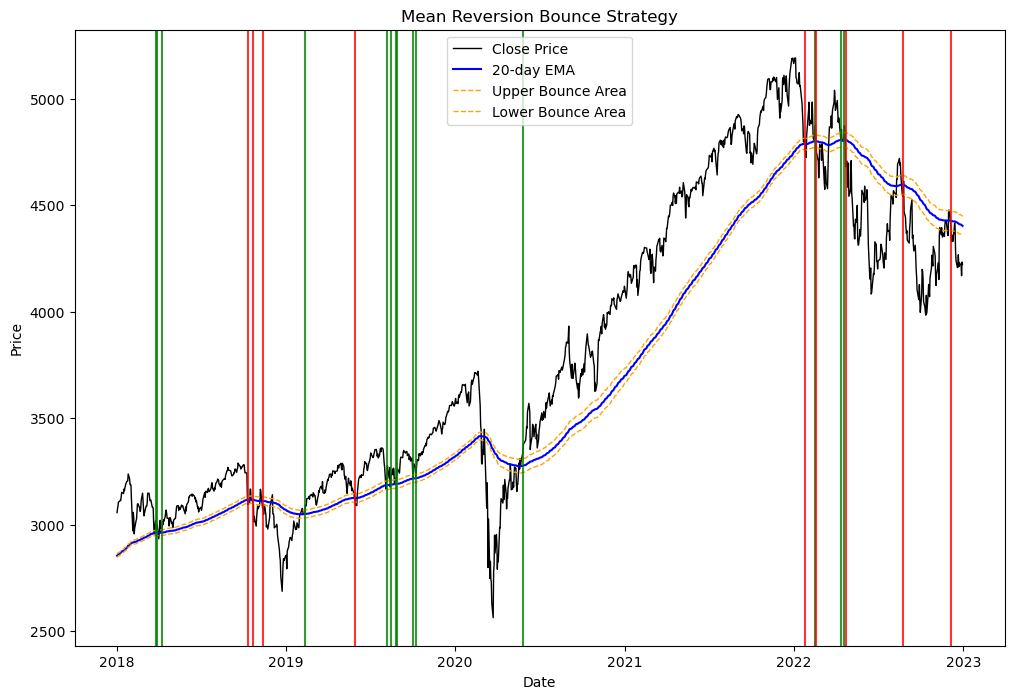

In [11]:
plot_mean_reversion_bounce(df, start_date='2018-01-01', end_date='2022-12-31')


In [14]:

def test_ema_bounce(asset_data, atr_period=14, atr_multiplier=0.5):
    """
    Tests every EMA period from 5 to 252 for a specific asset and returns a DataFrame 
    with the bounce percentage for each EMA period.
    
    :param asset_data: DataFrame containing the OHLC data for a specific asset.
    :param atr_period: Period for ATR calculation (default is 14).
    :param atr_multiplier: Multiplier for ATR to define the bounce area (default is 0.4).
    :return: DataFrame with EMA periods as index and bounce percentages as values.
    """
    ema_periods = range(5, 253)  # EMA periods from 5 to 252
    bounce_percentages = []

    for ema_period in ema_periods:
        # Run the mean reversion bounce function for the current EMA period
        df_with_signals = mean_reversion_bounce(asset_data, ema_period=ema_period, atr_period=atr_period, atr_multiplier=atr_multiplier)

        # Calculate the bounce percentage: (number of 1s) / (number of 1s + number of -1s)
        final_signals = df_with_signals['Final_Signal'].dropna()  # Drop NaN values
        num_successful_bounces = (final_signals == 1).sum()
        num_total_bounces = (final_signals == 1).sum() + (final_signals == -1).sum()

        # Calculate bounce percentage
        if num_total_bounces > 4:
            bounce_percentage = num_successful_bounces / num_total_bounces
        else:
            bounce_percentage = np.nan  # Avoid division by zero when there are no signals

        bounce_percentages.append(bounce_percentage)

    # Create a DataFrame with EMA periods as index and bounce percentages as values
    bounce_df = pd.DataFrame(bounce_percentages, index=ema_periods, columns=[asset_data.name])

    return bounce_df

# Example usage:
# Assuming `market_data` is an object that contains OHLC data for multiple assets, and we fetch a specific asset:
# asset_data = market_data.get_ticker_data('AAPL')  # Replace 'AAPL' with your asset
# asset_data.name = 'AAPL'  # Set the asset name (used in the result DataFrame)

# df_bounce_percentages = test_ema_bounce(asset_data)
# print(df_bounce_percentages)


In [15]:
testtick = 'EC1 Curncy'
asset_data = market_data.get_ticker_data(testtick)  # Replace 'AAPL' with your asset
asset_data.name = testtick  # Set the asset name (used in the result DataFrame)

df_bounce_percentages = test_ema_bounce(asset_data)
df_bounce_percentages

,EC1 Curncy
5,0.57
6,0.57
7,0.60
8,0.59
9,0.59
...,...
248,0.47
249,0.47
250,0.47
251,0.47


<Axes: >

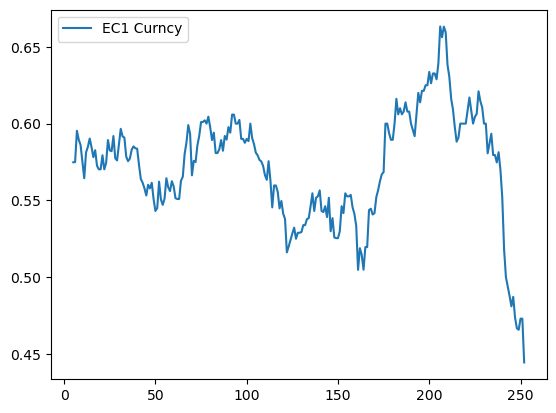

In [16]:
df_bounce_percentages.plot()

In [33]:
def calculate_bounce_percentage_bins(asset_data, ema_range=(5, 252), atr_period=20, atr_multiplier=0.5, bin_size=25):
    """
    Calculates the bounce percentage for various EMA periods and groups them into bins.
    
    :param asset_data: DataFrame for a single asset.
    :param ema_range: Range of EMA periods to test (default is from 5 to 252).
    :param atr_period: Period for ATR calculation (default is 20).
    :param atr_multiplier: Multiplier for ATR to define the bounce area (default is 0.5).
    :param bin_size: Bin size to group EMA periods (default is 25).
    :return: A DataFrame with the EMA bins as columns and bounce percentages as values.
    """
    # Step 1: Create a dictionary to store bounce percentages for each EMA period
    bounce_stats = {}

    # Step 2: Loop through each EMA period
    for ema_period in range(ema_range[0], ema_range[1] + 1):
        # Run the mean reversion bounce logic for the current EMA period
        df = mean_reversion_bounce(asset_data.copy(), ema_period, atr_period, atr_multiplier)

        # Count total bounces (1) and penetrations (-1)
        total_bounces = df['Final_Signal'].notna().sum()  # Count all 1s and -1s
        successful_bounces = (df['Final_Signal'] == 1).sum()  # Count only 1s

        # Calculate bounce percentage
        bounce_percentage = (successful_bounces / total_bounces) * 100 if total_bounces > 0 else np.nan

        # Store the bounce percentage for the current EMA period
        bounce_stats[ema_period] = bounce_percentage

    # Step 3: Create a DataFrame from bounce_stats
    bounce_df = pd.DataFrame.from_dict(bounce_stats, orient='index', columns=['Bounce_Percentage'])

    # Step 4: Create bins for the EMA periods
    bounce_df['EMA_Bin'] = pd.cut(bounce_df.index, bins=np.arange(0, ema_range[1] + bin_size, bin_size))

    # Step 5: Group the bounce percentages by bin and calculate the average for each bin
    bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()

    # Step 6: Return the results as a DataFrame
    return bounce_by_bin.reset_index()


def calculate_bounce_percentages_for_all_assets(market_data, ema_range=(5, 252), atr_period=20, atr_multiplier=0.5, bin_size=25):
    """
    Calculate bounce percentages for all assets in the market data over a range of EMA periods.
    
    :param market_data: A dictionary of DataFrames, one for each asset.
    :param ema_range: Range of EMA periods to test (default is (5, 252)).
    :param atr_period: Period for ATR calculation (default is 20).
    :param atr_multiplier: Multiplier for ATR to define the bounce area (default is 0.5).
    :param bin_size: Bin size for grouping EMA periods (default is 25).
    :return: A DataFrame with assets as rows and EMA bins as columns, containing the bounce percentages.
    """
    results = {}

    # Step 1: Loop over each asset in the market data
    for asset, asset_data in market_data.items():
        print(f"Processing {asset}...")  # For tracking progress

        # Step 2: Calculate bounce percentages for the asset using the bins
        bounce_stats = calculate_bounce_percentage_bins(asset_data, ema_range, atr_period, atr_multiplier, bin_size)

        # Step 3: Store results with asset as index
        results[asset] = bounce_stats.set_index('EMA_Bin')['Bounce_Percentage']

    # Step 4: Convert results dictionary into a DataFrame
    return pd.DataFrame(results).T  # Transpose to have assets as rows and bins as columns

# Example usage:
# Assuming 'mktdata' is a dictionary containing asset data
# all_asset_bounce_percentages = calculate_bounce_percentages_for_all_assets(mktdata)


In [23]:
mktdata = {}

for asset in market_data.get_data().keys():
    mktdata[asset] = market_data.get_ticker_data(asset)
    

In [27]:
test = calculate_bounce_percentage_bins(mktdata['ES1 Index'], bin_size=10)


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\3876129832.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


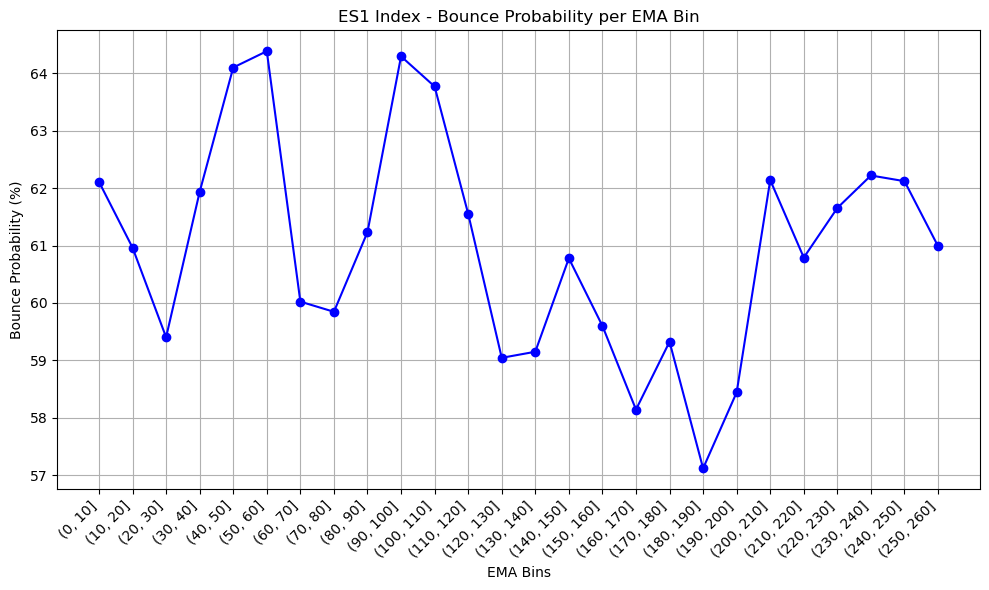

In [31]:

def plot_bounce_probability(test_df, asset_name=''):
    """
    Plots the bounce probability for each EMA bin.
    
    :param test_df: DataFrame containing the bins and bounce percentages.
    """
    # Plotting the bounce probabilities
    plt.figure(figsize=(10, 6))
    plt.plot(test_df['EMA_Bin'].astype(str), test_df['Bounce_Percentage'], marker='o', linestyle='-', color='blue')

    # Formatting the plot
    plt.title(f'{asset_name} - Bounce Probability per EMA Bin')
    plt.xlabel('EMA Bins')
    plt.ylabel('Bounce Probability (%)')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming `test` is the DataFrame containing the EMA bins and bounce percentages
plot_bounce_probability(test, 'ES1 Index')

In [34]:
all_asset_bounce_percentages = calculate_bounce_percentages_for_all_assets(mktdata)

Processing HG1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing LA1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing LN1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing LP1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing SCO1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing CL1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing CO1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing HO1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing MO1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing NG1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing QS1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing TZT2 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing XB1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing GC1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing PL1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing SI1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing BO1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing C 1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing CA1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing FC1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing KC1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing QC1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing QW1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing RR1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing RS1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing S 1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing SB1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing SM1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing W 1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing YW1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing BTC1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing DCR1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing NK1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing TP1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing XP1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing ASD3 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing DBE3 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing DED3 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing MND3 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing HC1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing KM1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing MES1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing XB1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing XU1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing CA1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing GX1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing VG1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing Z 1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing DM1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing ES1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing NQ1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing RTY1 Index...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing JB1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing BTS1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing DU1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing G 1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing IK1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing OAT1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing OE1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing RX1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing UB1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing CN1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing FV1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing TU1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing TY1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing US1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing WN1 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing AD1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing BP1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing CD1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing DX1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing EC1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing JY1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing KO1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing NV1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing PE1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing SF1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing XID1 Curncy...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing ER6 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing IR6 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing SFI6 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing SFR8 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


Processing SSY4 Comdty...


C:\Users\karsh\AppData\Local\Temp\ipykernel_2377604\2153077588.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_by_bin = bounce_df.groupby('EMA_Bin')['Bounce_Percentage'].mean()


In [35]:
all_asset_bounce_percentages.to_csv('all_asset_bounce_percentages.csv')

In [39]:
all_asset_bounce_percentages = all_asset_bounce_percentages / 100

In [40]:
all_asset_bounce_percentages.to_clipboard()